In [792]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [793]:
indir = '/mnt/store1/oliverphilcox/RealPowerCov2/PowerCovMatrices/'
n=100
l=4
m=l//2+1
R0 = 50
r_bins = np.loadtxt('/mnt/store1/oliverphilcox/RealPowerCov/linear_r_bins_R0_%d.csv'%R0)
r_cen = r_bins.mean(axis=1)
c2 = np.loadtxt(indir+'c2_leg_n%d_l%d_11_full.txt'%(n,l))
c3 = np.loadtxt(indir+'c3_leg_n%d_l%d_1,11_full.txt'%(n,l))
c4 = np.loadtxt(indir+'c4_leg_n%d_l%d_11,11_full.txt'%(n,l))
b2 = np.loadtxt(indir+'binct_c2_n%d_l%d_11_full.txt'%(n,l))
b3 = np.loadtxt(indir+'binct_c3_n%d_l%d_1,11_full.txt'%(n,l))
b4 = np.loadtxt(indir+'binct_c4_n%d_l%d_11,11_full.txt'%(n,l))
## Apply symmetries
c2 = 0.5*(c2+c2.T)
c3 = 0.5*(c3+c3.T)
c4 = 0.5*(c4+c4.T)
b2 = 0.5*(b2+b2.T)
b3 = 0.5*(b3+b3.T)
b4 = 0.5*(b4+b4.T)
c_tot = c2+c3+c4

In [794]:
#old_diag_b2 = np.diag(b2)[::m]

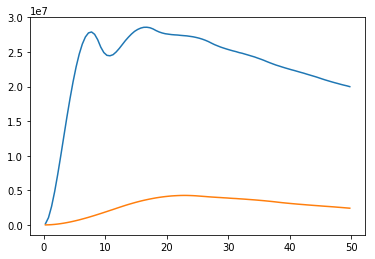

In [795]:
plt.plot(r_cen,np.diag(b2)[::m])
plt.plot(r_cen,old_diag_b2)

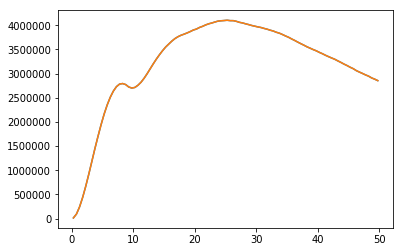

In [800]:
plt.plot(r_cen,b4[::m,::m][40]/delta_r)
plt.plot(r_cen,b4[::m,::m][:,40]/delta_r)

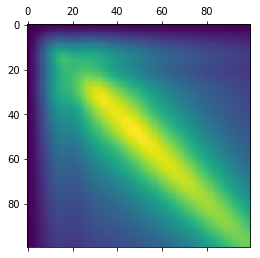

In [827]:
plt.matshow(mini_b3)

In [828]:
def rebinner(mat):
    new_mat = np.zeros_like(mat)
    m=len(mat)//n
    for i in range(m):
        for j in range(m):
            new_mat[n*i:n*(i+1),n*j:n*(j+1)]=mat[i::m,j::m]
    return new_mat

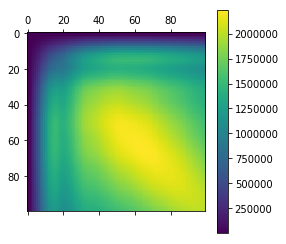

In [829]:
plt.matshow(rebinner(b4)[:n,:n])
plt.colorbar();

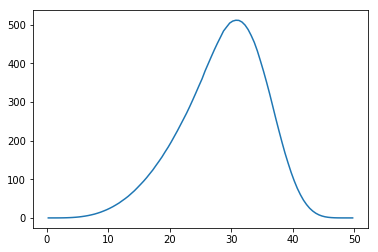

In [838]:
plt.plot(r_cen,np.diag(rebinner(c4))[:n])
#plt.xlim([0,10])
#plt.yscale('log');

In [852]:
def plotter(mat,perc=99.9):
    vmax=np.percentile(mat,perc)
    plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
    plt.colorbar();

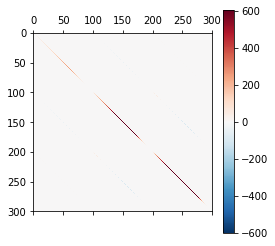

In [853]:
plotter(rebinner(c2))

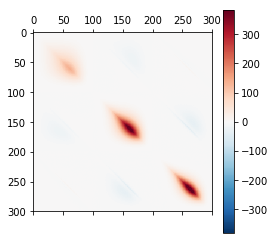

In [854]:
plotter(rebinner(c3))

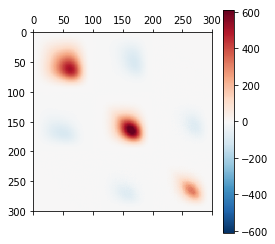

In [855]:
plotter(rebinner(c4))

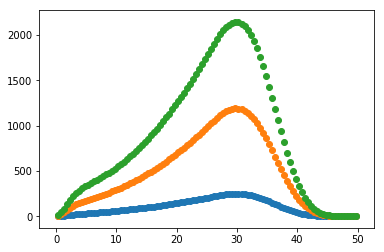

In [856]:
for i in range(3):
    plt.scatter(r_cen,np.diag(rebinner(c2))[i*n:(i+1)*n])
#plt.xlim([40,60])
#plt.xscale('log')

In [857]:
from scipy.special import sici,spherical_jn
def kernel_function(ell,kr):
    if ell==0:
        return spherical_jn(1,kr)*kr**2.
    elif ell==2:
        return kr*np.cos(kr)-4*np.sin(kr)+3.*sici(kr)[0]
    elif ell==4:
        return 0.5*((105./kr-2.*kr)*np.cos(kr)+(22.-105./kr**2.)*np.sin(kr)+15.*sici(kr)[0])
    else:
        raise Exception("Wrong ell")

In [920]:
k_all = np.arange(0.05,1.05,0.05)
k_lo = k_all[:-1]
k_hi = k_all[1:]
k_med = 0.5*(k_lo+k_hi)
nk = len(k_med)
this_kernel = np.zeros([m,nk,n])

for l_i in range(m):
    ell = 2*l_i
    for i in range(nk):
        if i==0:
            old_D_ell = kernel_function(ell,r_cen*k_lo[i])
        new_D_ell = kernel_function(ell,r_cen*k_hi[i])
        this_kernel[l_i,i] = (new_D_ell-old_D_ell)/pow(r_cen,3)*3.*pow(-1.,ell/2)/(k_hi[i]**3.-k_lo[i]**3.)
        old_D_ell = new_D_ell
        
## Flatten kernel to rebinned covariance
this_kernel_flat = np.zeros([m*nk,n])
for i in range(m*nk):
    this_kernel_flat[i] = this_kernel[i//nk,i%nk]

In [921]:
delta_r = r_bins[:,1]-r_bins[:,0]

cov2 = np.zeros([m,m,n])
for i in range(m):
    for j in range(m):
        cov2[i,j]=np.diag(c2[i::m,j::m])
        
power_cov2 = np.zeros([nk*m,nk*m])
for p in range(m):
    for q in range(m):
        for i in range(nk):
            for j in range(nk):
                power_cov2[p*nk+i,q*nk+j]=np.sum(cov2[p,q]*this_kernel[p,i]*this_kernel[q,j]*delta_r[i])
                
cov3 = np.zeros([m,m,n,n])
cov4 = np.zeros([m,m,n,n])
for i in range(m):
    for j in range(m):
        cov3[i,j]=c3[i::m,j::m]
        cov4[i,j]=c4[i::m,j::m]
        
power_cov3 = np.zeros([nk*m,nk*m])
power_cov4 = np.zeros([nk*m,nk*m])
for p in range(m):
    for q in range(m):
        for i in range(nk):
            for j in range(nk):
                vec1 = this_kernel[p,i]*delta_r[i]
                vec2 = this_kernel[q,j]*delta_r[j]
                tmp_mat=np.matmul(vec1.reshape(-1,1),vec2.reshape(1,-1))
                power_cov3[p*nk+i,q*nk+j]=np.sum(cov3[p,q]*tmp_mat)
                power_cov4[p*nk+i,q*nk+j]=np.sum(cov4[p,q]*tmp_mat)

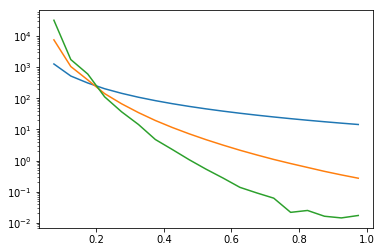

In [922]:
plt.plot(k_med,np.diag(power_cov2)[:nk],label=r'2-point')
plt.plot(k_med,np.diag(power_cov3)[:nk],label=r'3-point')
plt.plot(k_med,np.diag(power_cov4)[:nk],label=r'4-point')
plt.yscale('log');

In [903]:
vec1 = this_kernel[2,7]*delta_r[7]
vec2 = this_kernel[1,j]*delta_r[j]
tmp_mat=np.matmul(vec1.reshape(-1,1),vec2.reshape(1,-1))
                

In [887]:
x=np.matmul(vec1.reshape(-1,1),vec2.reshape(1,-1))
x-x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

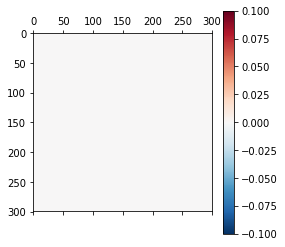

In [878]:
plotter(c4-c4.T,perc=100)

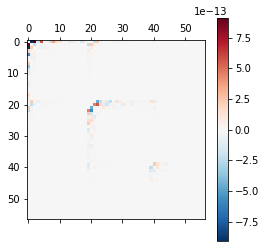

In [883]:
plotter(power_cov4-power_cov4.T,perc=100)

In [866]:
power_tot = power_cov2+power_cov3+power_cov4
def corr_mat(mat):
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)):
        for j in range(len(mat)):
            out_mat[i,j]=mat[i,j]/np.sqrt(mat[i,i]*mat[j,j])
    return out_mat

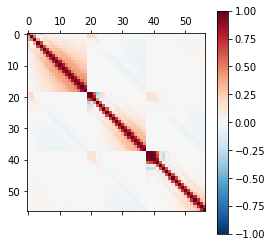

In [865]:
plotter(corr_mat(power_tot))

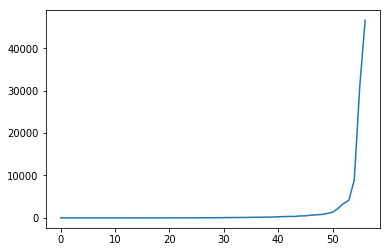

In [871]:
plt.plot(np.linalg.eigvalsh(power_tot))

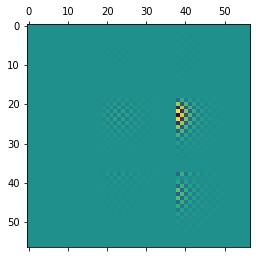

In [824]:
plt.matshow(np.linalg.inv(power_tot))

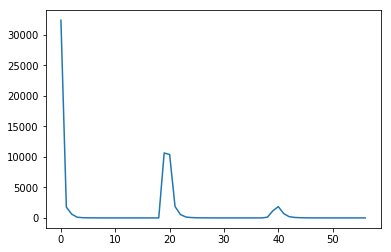

In [810]:
plt.plot(np.diag(power_cov4))

(30, 0)

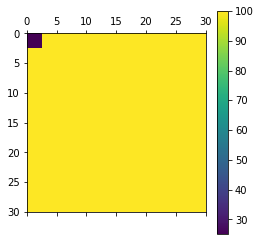

In [811]:
plt.matshow(b3,vmax=100);plt.colorbar();plt.xlim([0,30]);plt.ylim([30,0])

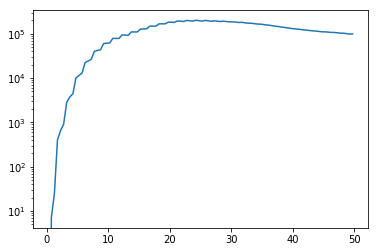

In [768]:
plt.plot(r_cen,np.diag(b3[::3])/delta_r)
plt.yscale('log')

## Want more uniform sampling!!

## We are not sampling super low $r$ here? Just a fundamental limit on r separation? But only in C3 and C4 matrices? - need more samples here!!

In [46]:
this_kernel_flat.shape

(57, 110)

### maybe weight sampling strategy more to low r?

### Combine Integrals

In [291]:
## Get 2-point C2 model:
cov2 = np.zeros([m,m,n])
for i in range(m):
    for j in range(m):
        cov2[i,j]=np.diag(c2[i::m,j::m])
        
from scipy.interpolate import UnivariateSpline
cov2_spl_list=[]
for i in range(m):
    tmp_spl_list=[]
    for j in range(m):
        tmp_spl_list.append(UnivariateSpline(r_cen,cov2[i,j]))
    cov2_spl_list.append(tmp_spl_list)

In [292]:
## Get 3-point C3 model:
cov3 = np.zeros([m,m,n,n])
for i in range(m):
    for j in range(m):
        cov3[i,j]=c3[i::m,j::m]
        
## Get 4-point C4 model:
cov4 = np.zeros([m,m,n,n])
for i in range(m):
    for j in range(m):
        cov4[i,j]=c4[i::m,j::m]

## Try 2-point integral

In [293]:
delta_r = r_bins[:,1]-r_bins[:,0]
def two_point_power(k1,k2,p,q):
    p_i = p//2
    q_i = q//2
    x = spherical_jn(p,k1*r_cen)*spherical_jn(q,k2*r_cen)*delta_r*cov2[p_i,q_i]*pow(-1,p_i+q_i)
    return np.sum(x)
def three_point_power(k1,k2,p,q):
    p_i = p//2
    q_i = q//2
    x1 = spherical_jn(p,k1*r_cen)*delta_r
    x2 = spherical_jn(q,k2*r_cen)*delta_r
    x = np.matmul(x1.reshape(-1,1),x2.reshape(1,-1))*cov3[p_i,q_i]
    return np.sum(x.ravel())*pow(-1,p_i+q_i)
def four_point_power(k1,k2,p,q):
    p_i = p//2
    q_i = q//2
    x1 = spherical_jn(p,k1*r_cen)*delta_r
    x2 = spherical_jn(q,k2*r_cen)*delta_r
    x = np.matmul(x1.reshape(-1,1),x2.reshape(1,-1))*cov4[p_i,q_i]
    return np.sum(x.ravel())*pow(-1,p_i+q_i)

## Get better r resolution

In [294]:
from scipy.special import sici
def kernel_function(ell,kr):
    if ell==0:
        return spherical_jn(1,kr)*kr**2.
    elif ell==2:
        return kr*np.cos(kr)-4*np.sin(kr)+3.*sici(kr)[0]
    elif ell==4:
        return 0.5*((105./kr-2.*kr)*np.cos(kr)+(22.-105./kr**2.)*np.sin(kr)+15.*sici(kr)[0])
    else:
        raise Exception("Wrong ell")

In [295]:
def full_kernel(ell,k,r):
    return 3.*pow(-1,ell/2.)/r**3*kernel_function(ell,k*r)

In [296]:
k_all = np.arange(0.05,1.05,0.05)
k_lo = k_all[:-1]
k_hi = k_all[1:]
k_med = 0.5*(k_lo+k_hi)
nk = len(k_med)
this_kernel = np.zeros([m,nk,n])

# First define all kernel functions
for p in range(m):
    for i in range(nk):
        if i==0:
            old_kernel = full_kernel(p*2,k_lo[i],r_cen)*delta_r
        new_kernel = full_kernel(p*2,k_hi[i],r_cen)*delta_r
        this_kernel[p,i] = (new_kernel-old_kernel)/(k_hi[i]**3.-k_lo[i]**3.)
        old_kernel = new_kernel

In [297]:
# now define 2-point power
pow2 = np.zeros([nk*m,nk*m])
for p in range(m):
    for q in range(m):
        for i in range(nk):
            for j in range(nk):
                tmp = np.matmul(this_kernel[p,i].reshape(-1,1),this_kernel[q,j].reshape(1,-1))*cov2[p,q]
                pow2[p*nk+i,q*nk+j] = np.sum(tmp)

## why not symmetric??

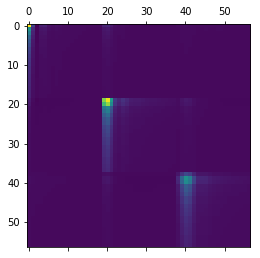

In [298]:
plt.matshow(pow2)

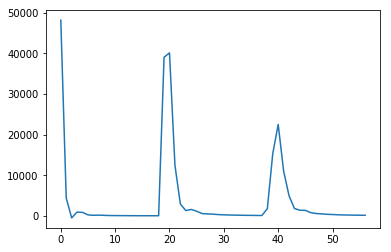

In [299]:
plt.plot(np.diag(pow2))

In [270]:
tmp.sum()

5.487533721610028

In [ ]:
def two_point_binned_power(ell)

In [249]:
kernel_function(0,0.1*r_cen)

array([ 6.51031494e-07,  1.75756532e-05,  8.13484236e-05,  2.23136369e-04,
        4.74008969e-04,  8.64899269e-04,  1.42656511e-03,  2.18955056e-03,
        3.18414745e-03,  4.44035730e-03,  5.98785336e-03,  7.85594308e-03,
        1.00735308e-02,  1.26690810e-02,  1.56705818e-02,  1.91055090e-02,
        2.30007903e-02,  2.73827707e-02,  3.22771780e-02,  3.77090885e-02,
        4.37028944e-02,  5.02822704e-02,  5.74701427e-02,  6.52886569e-02,
        7.37591481e-02,  8.29021109e-02,  9.27371704e-02,  1.03283055e-01,
        1.14557566e-01,  1.26577558e-01,  1.39358904e-01,  1.52916481e-01,
        1.67264136e-01,  1.82414673e-01,  1.98379825e-01,  2.15170237e-01,
        2.32795443e-01,  2.51263850e-01,  2.70582723e-01,  2.90758162e-01,
        3.11795092e-01,  3.33697249e-01,  3.56467163e-01,  3.80106152e-01,
        4.04614307e-01,  4.29990484e-01,  4.56232296e-01,  4.83336106e-01,
        5.11297022e-01,  5.40108892e-01,  5.69764300e-01,  6.00254564e-01,
        6.31569738e-01,  

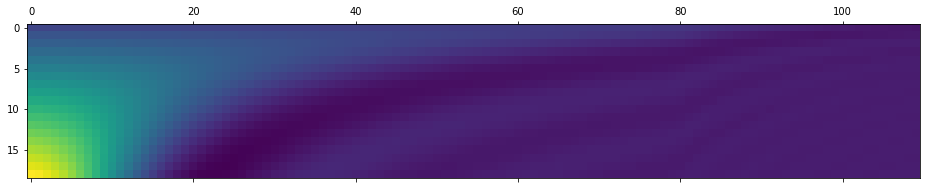

In [259]:
plt.matshow(this_kernel[0])

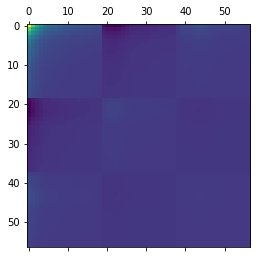

In [266]:
plt.matshow(pow2)

## Try this binned

#### should vectorize

In [211]:
k_all = np.arange(0.05,1.05,0.005)
nk = len(k_all)
pow2 = np.zeros([nk*m,nk*m])
for p in range(m):
    for q in range(m):
        for i in range(nk):
            for j in range(nk):
                pow2[nk*p+i,nk*q+j] = two_point_power(k_all[i],k_all[j],p*2,q*2)

In [212]:
pow3 = np.zeros([nk*m,nk*m])
for p in range(m):
    for q in range(m):
        for i in range(nk):
            for j in range(nk):
                pow3[nk*p+i,nk*q+j] = three_point_power(k_all[i],k_all[j],p*2,q*2)

In [213]:
pow4 = np.zeros([nk*m,nk*m])
for p in range(m):
    for q in range(m):
        for i in range(nk):
            for j in range(nk):
                pow4[nk*p+i,nk*q+j] = four_point_power(k_all[i],k_all[j],p*2,q*2)

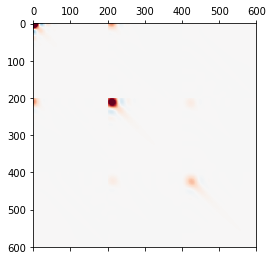

In [214]:
mat = pow4+pow3+pow2
vmax = np.percentile(mat,99.9)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)

In [220]:
def corr_mat(mat):
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)):
        for j in range(len(mat)):
            out_mat[i,j]=mat[i,j]/np.sqrt(mat[i,i]*mat[j,j])
    return out_mat

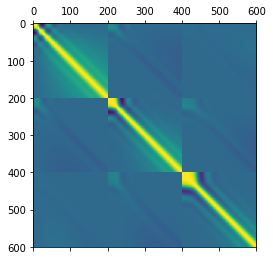

In [222]:
plt.matshow(corr_mat(mat))

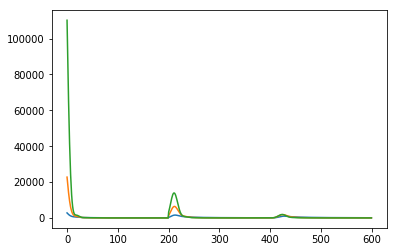

In [215]:
plt.plot(np.diag(pow2))
plt.plot(np.diag(pow3))
plt.plot(np.diag(pow4))

## Need better spline approximation

In [175]:
r_mesh1,r_mesh2 = np.meshgrid(r_cen,r_cen)

In [176]:
from scipy.interpolate import SmoothBivariateSpline
cov3_spl_list=[]
for i in range(1):
    tmp_spl_list=[]
    for j in range(1):
        tmp_spl_list.append(SmoothBivariateSpline(r_mesh1.ravel(),r_mesh2.ravel(),cov3[i,j].ravel(),kx=3,ky=3))
    cov3_spl_list.append(tmp_spl_list)

In [177]:
from scipy.interpolate import SmoothBivariateSpline
cov4_spl_list=[]
for i in range(1):
    tmp_spl_list=[]
    for j in range(1):
        tmp_spl_list.append(SmoothBivariateSpline(r_mesh1.ravel(),r_mesh2.ravel(),cov4[i,j].ravel(),kx=5,ky=5))
    cov4_spl_list.append(tmp_spl_list)

In [178]:
cov3_approx = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        cov3_approx[i,j]=cov3_spl_list[0][0](r_cen[i],r_cen[j])

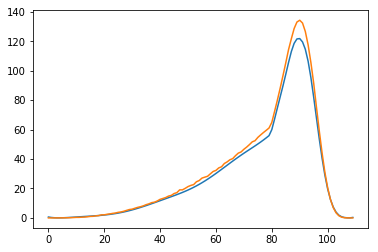

In [179]:
plt.plot(np.diag(cov3_approx))
plt.plot(np.diag(cov3[0,0]))

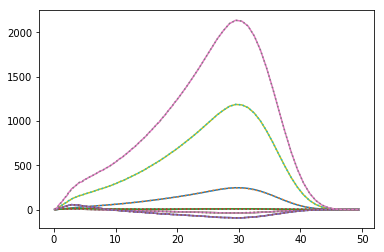

In [60]:
for i in range(m):
    for j in range(m):
        plt.plot(r_cen,cov2[i,j]);
        plt.plot(r_cen,cov2_spl_list[i][j](r_cen),ls=':')

In [61]:
from scipy.integrate import quad, dblquad
from scipy.special import spherical_jn
def two_point(k_a,k_b,p,q):
    p_i = p//2
    q_i = q//2
    pref = pow(-1,0.5*p+0.5*q)
    ints = quad(lambda w: cov2_spl_list[p_i][q_i](w)*spherical_jn(p,k_a*w)*spherical_jn(q,k_b*w),0,R0)
    return ints[0]

def three_point(k_a,k_b,p,q):
    p_i = p//2
    q_i = q//2
    pref = pow(-1,0.5*p+0.5*q)
    ints = dblquad(lambda w1,w2: cov3_spl_list[p_i][q_i](w1,w2)*spherical_jn(p,k_a*w1)*spherical_jn(q,k_b*w2),0,R0,0,R0)
    return ints[0]

def four_point(k_a,k_b,p,q):
    p_i = p//2
    q_i = q//2
    pref = pow(-1,0.5*p+0.5*q)
    ints = dblquad(lambda w1,w2: cov4_spl_list[p_i][q_i](w1,w2)*spherical_jn(p,k_a*w1)*spherical_jn(q,k_b*w2),0,R0,0,R0)
    return ints[0]

In [118]:
def two_point(k,p,q):
    x=spherical_jn(p,k*r_cen)*spherical_jn(q,k*r_cen)*delta_r*cov2[p,q]
    out = np.sum(x)
    return out

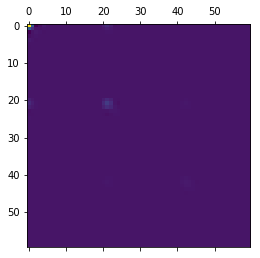

In [207]:
plt.matshow(pow)

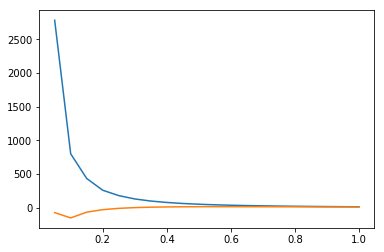

In [126]:
k_all = np.arange(0.05,1.05,0.05)
pow2 = np.asarray([two_point(k,0,0) for k in k_all])
plt.plot(k_all,pow2)
pow2 = np.asarray([two_point(k,1,2) for k in k_all])
plt.plot(k_all,pow2)

In [125]:
k_a = 0.1
k_b = 0.15
x=spherical_jn(0,k_a*r_cen)*delta_r
y=spherical_jn(0,k_b*r_cen)*delta_r
mat_xy = np.matmul(x.reshape(-1,1),y.reshape(1,-1))

In [93]:
delta_r = r_bins[:,1]-r_bins[:,0]

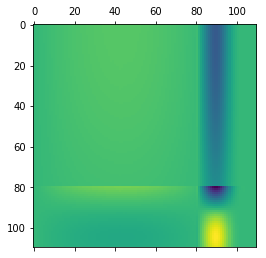

In [94]:
plt.matshow(mat_xy*cov2_00)

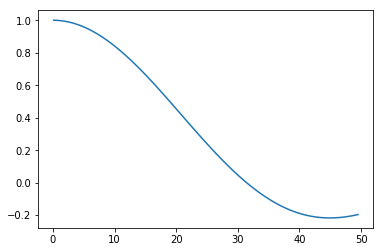

In [81]:
plt.plot(r_cen,x)

In [62]:
k_all = np.arange(0.05,1.05,0.025)
nk = len(k_all)

power_2pt = np.zeros([nk,nk])
for i in range(nk):
    for j in range(nk):
        power_2pt[i,j] = two_point(k_all[i],k_all[j],0,0)

In [67]:
k_all = np.arange(0.05,1.1,0.1)
nk = len(k_all)

power_3pt = np.zeros([nk,nk])
for i in range(nk):
    for j in range(nk):
        power_3pt[i,j] = three_point(k_all[i],k_all[j],0,0)

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


KeyboardInterrupt: 

In [ ]:
k_all = np.arange(0.05,1.1,0.1)
nk = len(k_all)

power_4pt = np.zeros([nk,nk])
for i in range(nk):
    for j in range(nk):
        power_4pt[i,j] = four_point(k_all[i],k_all[j],0,0)

In [ ]:
plt.plot(np.linalg.eigvalsh(power_2pt))

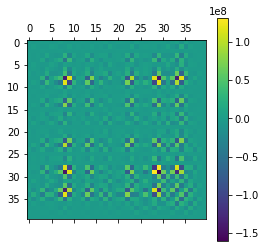

In [64]:
plt.matshow(np.linalg.inv(power_2pt));plt.colorbar();

In [249]:
r_bins = list(np.arange(0.,20,0.25))+list(np.arange(20.,101.,1.))

r_lo = r_bins[:-1]
r_hi = r_bins[1:]

outfile = '/mnt/store1/oliverphilcox/RealPowerCov/all_r_bins_R0_100.csv'
with open(outfile,"w") as out:
    for i in range(len(r_lo)):
        out.write("%.8f\t%.8f\n"%(r_lo[i],r_hi[i]))

In [339]:
r_bins = list(np.arange(0.,20,0.25))+list(np.arange(20.,51.,1.))

r_lo = r_bins[:-1]
r_hi = r_bins[1:]

outfile = '/mnt/store1/oliverphilcox/RealPowerCov/all_r_bins_R0_50.csv'
with open(outfile,"w") as out:
    for i in range(len(r_lo)):
        out.write("%.8f\t%.8f\n"%(r_lo[i],r_hi[i]))

In [250]:
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(r_cen,np.diag(c2[::3,::3]))

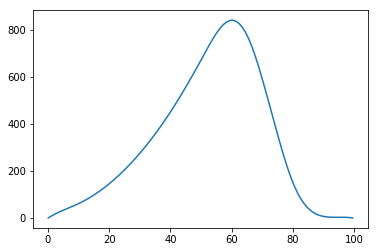

In [251]:
plt.plot(r_cen,spl(r_cen))

In [252]:
from scipy.integrate import quad
from scipy.special import spherical_jn
def k_int(k):
    out=quad(lambda r: spherical_jn(0,k*r)**2.*spl(r),0,100)[0]
    return out

In [253]:

len(r_lo)

160

In [254]:
np.asarray(r_bins)

array([  0.  ,   0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,
         2.  ,   2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,
         4.  ,   4.25,   4.5 ,   4.75,   5.  ,   5.25,   5.5 ,   5.75,
         6.  ,   6.25,   6.5 ,   6.75,   7.  ,   7.25,   7.5 ,   7.75,
         8.  ,   8.25,   8.5 ,   8.75,   9.  ,   9.25,   9.5 ,   9.75,
        10.  ,  10.25,  10.5 ,  10.75,  11.  ,  11.25,  11.5 ,  11.75,
        12.  ,  12.25,  12.5 ,  12.75,  13.  ,  13.25,  13.5 ,  13.75,
        14.  ,  14.25,  14.5 ,  14.75,  15.  ,  15.25,  15.5 ,  15.75,
        16.  ,  16.25,  16.5 ,  16.75,  17.  ,  17.25,  17.5 ,  17.75,
        18.  ,  18.25,  18.5 ,  18.75,  19.  ,  19.25,  19.5 ,  19.75,
        20.  ,  21.  ,  22.  ,  23.  ,  24.  ,  25.  ,  26.  ,  27.  ,
        28.  ,  29.  ,  30.  ,  31.  ,  32.  ,  33.  ,  34.  ,  35.  ,
        36.  ,  37.  ,  38.  ,  39.  ,  40.  ,  41.  ,  42.  ,  43.  ,
        44.  ,  45.  ,  46.  ,  47.  ,  48.  ,  49.  ,  50.  ,  51.  ,
      

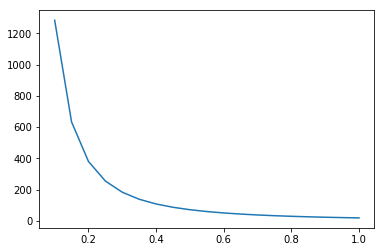

In [255]:
k_all = np.arange(0.1,1.05,0.05)
ints_k = [k_int(kk) for kk in k_all]
plt.plot(k_all,ints_k)

In [5]:
mat = rebinner(c2)
imat = np.linalg.inv(mat)

In [6]:
def red_mat(mat):
    m=len(mat)//n
    new_mat = np.zeros_like(mat)
    for i in range(len(mat)):
        for j in range(len(mat)):
            new_mat[i,j]=mat[i,j]/np.sqrt(mat[i,i]*mat[j,j])
    return new_mat

In [7]:
plt.matshow(mat_old)

NameError: name 'mat_old' is not defined

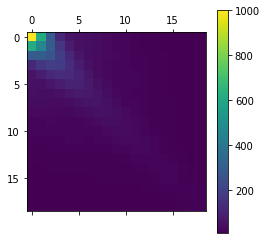

In [286]:
plt.matshow(mat);plt.colorbar();

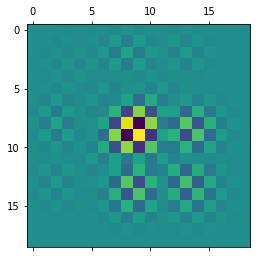

In [287]:
plt.matshow(np.linalg.inv(mat))

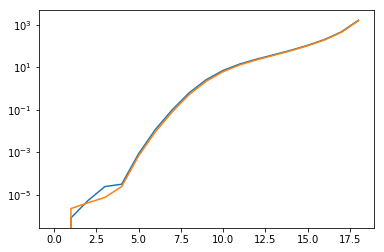

In [288]:
#plt.plot(1./np.linalg.eigvalsh(imat)[::-1])
plt.plot(np.linalg.eigvalsh(mat))
plt.plot(np.linalg.eigvalsh(mat_old))
plt.yscale('log')

In [45]:
mat

array([[918.0456  , 581.0744  , 290.1894  , 122.4203  ,  61.49255 ,
         50.04406 ,  45.98572 ,  37.82318 ,  29.15288 ,  22.98698 ,
         18.69089 ,  15.08635 ,  12.0218  ,   9.725481,   8.145563,
          7.011053,   6.090129,   5.284215,   4.584516],
       [581.0744  , 443.5299  , 290.421   , 163.819   ,  86.20139 ,
         52.42254 ,  41.70048 ,  36.31433 ,  29.94901 ,  23.55543 ,
         18.6417  ,  15.08838 ,  12.28769 ,  10.03336 ,   8.325239,
          7.066864,   6.097827,   5.300769,   4.616572],
       [290.1894  , 290.421   , 253.5015  , 185.1125  , 113.9815  ,
         64.97498 ,  42.06108 ,  33.97992 ,  29.33604 ,  24.09372 ,
         19.06139 ,  15.26207 ,  12.527   ,  10.36246 ,   8.587166,
          7.200473,   6.151361,   5.331246,   4.647513],
       [122.4203  , 163.819   , 185.1125  , 171.1327  , 129.9485  ,
         83.71538 ,  50.55578 ,  34.17231 ,  27.72695 ,  23.80401 ,
         19.65757 ,  15.77856 ,  12.82216 ,  10.63838 ,   8.877033,
          7.4

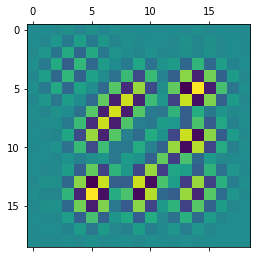

In [46]:
plt.matshow(np.linalg.inv(mat))

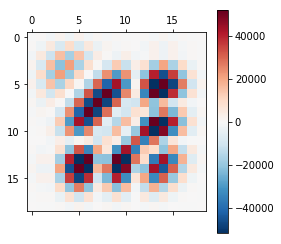

In [47]:
mat = np.linalg.inv(rebinner(c2))
vmax = np.percentile(mat,99.)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
plt.colorbar();

In [73]:
np.save('theory_power_cov.npy',mat)

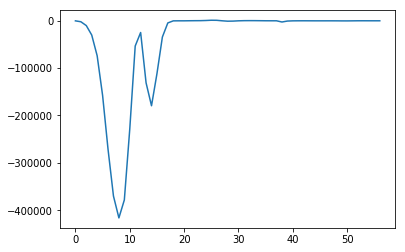

In [72]:
plt.plot(np.diag(np.linalg.inv(mat)))

In [226]:
from scipy.integrate import quad
def quad_int(nn):
    fun = lambda x: -x/nn*(np.exp(-((x+nn)/20)**2.)-np.exp(-((x-nn)/20)**2.))/(0.1+x)**4.
    out=quad(fun,0,np.inf)
    return out[0]

In [224]:
qq1=np.asarray([quad_int(n) for n in nn])

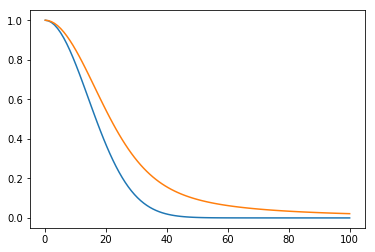

In [227]:
nn = np.linspace(0.1,100,100)
qq=np.asarray([quad_int(n) for n in nn])
plt.plot(nn,qq/qq[0])
plt.plot(nn,qq1/qq1[0])